NOTEARS (and OMP) always seem to be able to predict the correct direction, even in just two dimensions. How is this possible? This is most likely when we have equal variance across all variables, e.g. additive noise with variance 1. However, what happens when variance levels are unequal? Will NOTEARS still perform well? Let us find out.

In [9]:
import itertools                 # permutations
import numpy as np               # computations
import matplotlib.pyplot as plt  # plotting
from tqdm import tqdm            # time of for loops
from timeit import default_timer as timer # timer

# import our own modules
import sys
sys.path.append("..")

# import our own helper
import helper.helper as h

# import NOTEARS
from notears.notears.notears import linear
from notears.notears.notears import utils

from importlib import reload  # Python 3.4+
reload(utils)

<module 'notears.notears.notears.utils' from '..\\notears\\notears\\notears\\utils.py'>

0.75 2 0.75
Corresponding W1:
[[0.74939 1.99965]
 [0.      0.75   ]].

Should be close to:
[[0.75 2.  ]
 [0.   0.75]].
a:  3.41552. Should be close to: 0.75.
Corresponding W2:
[[ 7.4994e-01  0.0000e+00]
 [-1.6000e-04  9.5818e-01]].

MSE using W1: 4.996.
MSE using W2: 28.475.


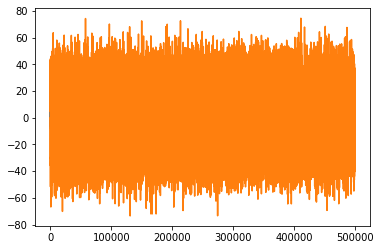

In [120]:
# utils.set_random_seed(3)
a, b, c, s1, s2 = 0.75, 2, 0.75, 2, 1, #np.random.random(), np.random.random()
T, n, s0, graph_type, sem_type = 500000, 2, 1, 'ER', 'gauss'
W_true = np.array([[a, b], [0.0, c]])
X = utils.simulate_var(W_true, T, noise_scale = [s1, s2])

print(a, b, c)

plt.plot(X)

X_pred = X[:-1].copy()
X_val = X[1:].copy()


## Approach 1: Use top right:
W1 = np.zeros((n, n))

# First Column, only X to predict X
W1[0][0] = np.linalg.inv((X_pred[:, 0].T @ X_pred[:, 0]).reshape(1, 1)) * X_pred[:, 0].T @ X_val[:, 0]

# Second Column, X and Y to predict Y
W1[:, 1] = np.linalg.inv((X_pred.T @ X_pred)) @ X_pred.T @ X_val[:, 1]

print(f"Corresponding W1:\n{np.round(W1, 5)}.\n")
print(f"Should be close to:\n{W_true}.")

## Approach 2: Use bottom left.
W2 = np.zeros((n, n))

# First Column, X and Y to predict X
W2[:, 0] = np.linalg.inv((X_pred.T @ X_pred)) @ X_pred.T @ X_val[:, 0]

# Second Column, Y to predict Y
W2[1][1] = np.linalg.inv((X_pred[:, 1].T @ X_pred[:, 1]).reshape(1, 1)) * X_pred[:, 1].T @ X_val[:, 1]

print(f"a:  {round(1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1], 5)}. Should be close to: {round(a, 5)}.")
print(f"Corresponding W2:\n{np.round(W2, 5)}.\n")

print(f"MSE using W1: {round(h.MSE(W1, X), 3)}.")
print(f"MSE using W2: {round(h.MSE(W2, X), 3)}.")

# W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2-var", verbose = False, w_threshold = 1e-2)
# print(np.round(W_NOTEARS, 2))
# print(f"Pick W2 if {a ** 2 + (s2 / s1) ** 2} is larger than 1. => {(a ** 2 + (s2 / s1) ** 2 > 1) == (W_NOTEARS[0][1] != 0)}")

# print(f"True W:\n{np.round(W_true, 2)}.")

# print(f"NOTEARS W:\n{np.round(W_NOTEARS, 2)}.")

Under correct direction, we expect to retrieve the correct W, no matter the values, as long as T is large enough.
Under the incorrect direction, we expect to retrieve the correct a, but we cannot expect to retrieve the correct b and c. Now, all information that b and c had need to be condensed into c. We have an addtional coefficient d, but that will be zero.

Larger variance in Y seems to disturb things though.

In [850]:
T = 1000

for _ in range(100):
    # get a, s1, s2
    a, s1, s2 = 0.0 + np.random.random(), np.random.random(), np.random.random()
    
    # remake W
    W_true = np.array([[0.0, a], [0.0, 0.0]])
    
    # generate X
    X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
    
    # do NOTEARS
    W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-4)
    
    # Verify    
    if len(W_NOTEARS[W_NOTEARS > 0]) == 1:
        print(f"Pick W2 if {round(a ** 2 + (s2 / s1) ** 2, 2)} is larger than 1. => {(a ** 2 + (s2 / s1) ** 2 > 1) == (W_NOTEARS[0][1] > 0)}. MSE(W1) < MSE(W2):", end = ' ')

        if (a ** 2 + (s2 / s1) ** 2 > 1) != (W_NOTEARS[0][1] > 0) :
            print(W_NOTEARS[W_NOTEARS != 0], a, s1, s2)

        W1 = np.zeros((n, n))
        W1[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]

        W2 = np.zeros((n, n))
        W2[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]

        # print(a ** 2 + (s2 / s1) ** 2 > 1)
        print(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True)) # , h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))

Pick W2 if 2.28 is larger than 1. => True. MSE(W1) < MSE(W2): 1.2934944688111285 1.1699492638169033
Pick W2 if 1.9 is larger than 1. => True. MSE(W1) < MSE(W2): 1.6125601083178636 1.4640677878618298
Pick W2 if 176.95 is larger than 1. => True. MSE(W1) < MSE(W2): 0.912557024038679 0.9121472557277789
Pick W2 if 50.41 is larger than 1. => True. MSE(W1) < MSE(W2): 0.9605374001310027 0.9457920647953204
Pick W2 if 0.25 is larger than 1. => True. MSE(W1) < MSE(W2): 0.06875555693634998 0.1073174026625723
Pick W2 if 11.18 is larger than 1. => True. MSE(W1) < MSE(W2): 1.0586447181105911 1.046701831474802
Pick W2 if 2.31 is larger than 1. => True. MSE(W1) < MSE(W2): 0.9957706992694123 0.9750556600041445
Pick W2 if 3.86 is larger than 1. => True. MSE(W1) < MSE(W2): 0.14076819644266328 0.138231697995969
Pick W2 if 0.59 is larger than 1. => True. MSE(W1) < MSE(W2): 0.8305060209439294 0.8867308015833293
Pick W2 if 2.14 is larger than 1. => True. MSE(W1) < MSE(W2): 0.369437081240752 0.3598226779116598

Pick W2 if 3.2 is larger than 1. => True. MSE(W1) < MSE(W2): 1.6189282289730904 1.3691772050359774


NOTEARS seems to pick the coefficient such that the MSE is minimized.

#### What are the two possibilities?
We have two choices, we either decide that Y predicts X, so X = aY, or that X predicts Y, so Y = a'X. The question is, what are the two values for a and a' based on our data X and Y? They are the minimizers of the MSE, which can easily be derived by OLS. However, since we know the data generating distribution, we can determine these a and a' for the population setting.

In [885]:
W1 = np.zeros((n, n))
W1[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]
print(f"a': {round(1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0], 5)}. Should be close to: {round(a * s1 ** 2 / (a ** 2 * s1 ** 2 + s2 ** 2), 5)}.")
print(f"Corresponding W1:\n{np.round(W1, 3)}.\n")

W2 = np.zeros((n, n))
W2[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]
print(f"a:  {round(1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1], 5)}. Should be close to: {round(a, 5)}.")
print(f"Corresponding W2:\n{np.round(W2, 3)}.\n")

a': -0.84667. Should be close to: -0.83888.
Corresponding W1:
[[ 0.     0.   ]
 [-0.847  0.   ]].

a:  -0.30874. Should be close to: -0.30791.
Corresponding W2:
[[ 0.    -0.309]
 [ 0.     0.   ]].



In [886]:
mse = 0
for row in X:
    mse += np.linalg.norm(row - row @ W1, 2) ** 2
print(mse / 100)

6.160181063739462


In [887]:
print(f"MSE using W1: {round(h.MSE(W1, X, is_sem = True), 3)}.")
print(f"MSE using W2: {round(h.MSE(W2, X, is_sem = True), 3)}.")
print(f"NOTEARS picks W minimizing MSE: {np.nonzero(W_NOTEARS) == np.nonzero([W1, W2][np.argmin([h.MSE(W1, X, True), h.MSE(W2, X, True)])])}.")

MSE using W1: 0.062.
MSE using W2: 0.071.
NOTEARS picks W minimizing MSE: True.


#### What determines when which one is picked?

In [888]:
print(np.linalg.norm(X - X @ W1, 'f') ** 2 / T)
print(np.var(X - X @ W1, axis = 0).sum() + np.sum(np.mean(X - X @ W1, axis = 0) ** 2))

print(np.linalg.norm(X - X @ W2, 'f') ** 2 / T)
print(np.var(X - X @ W2, axis = 0).sum() + np.sum(np.mean(X - X @ W2, axis = 0) ** 2))

0.06160181063739464
0.06160181063739452
0.07087522130877197
0.07087522130877194


One Way: $$\mathbb{V}(X_1) + \mathbb{V}(X_2 - X_2') = \sigma_1^2 + \sigma_2^2$$
Second Way: $$\mathbb{V}(X_1 - X_1') + \mathbb{V}(X_2) = \mathbb{V}(X_1(1 - a' a)) + \mathbb{V}(X_2)$$

In [889]:
a2 = a * s1 ** 2 / (a ** 2 * s1 ** 2 + s2 ** 2)

In [892]:
print("First approach, proper model fit (W2).")
print(f"Variance of X1: {round(np.var(X, axis = 0)[0], 3)}. Should be close to {round(s1 ** 2, 3)}.")
print(f"Variance of X2: {round(np.var(X[:, 1] - W2[0][1] * X[:, 0]), 3)}. Should be close to {round(s2 ** 2, 3)}.")

print("\nSecond approach, incorrect model fit (W1).")
print(f"Variance of X1: {round(np.var(X, axis = 0)[0] * (1 - W2[0][1] * W1[1][0]), 3)}. Should be close to {round(s1 ** 2 * (1 - a * a2), 3)}")
print(f"Variance of X2: {round(np.var(X, axis = 0)[1], 3)}. Should be close to {round(a ** 2 * s1 ** 2 + s2 ** 2, 3)}.")

First approach, proper model fit (W2).
Variance of X1: 0.056. Should be close to 0.055.
Variance of X2: 0.015. Should be close to 0.015.

Second approach, incorrect model fit (W1).
Variance of X1: 0.041. Should be close to 0.041
Variance of X2: 0.02. Should be close to 0.02.


Normally, we have X1 = noise and X2 = aX1 + noise. We get estimator X1' = 0, X2' = aX2. Our MSE is sigma1^2 + sigma2^2.
Now, we do X1' = a'X2, and X2' = 0. Our MSE second part is V(aX1 + noise) = a^2 sigma1^2 + sigma2^2.
Our MSE first part is V(X1 - X1') = V(X1 - a'X2) = sigma1^2, a' ** 2 sigma2 ^2.
a'X2 = a'(aX1 + sigma2)

We pick W1 when MSE(W1) < MSE(W2), so when s1 ** 2 + s2 ** 2 < s1 ** 2 

In [893]:
print(f"MSE(W2): {h.MSE(W2, X, True)}, {s1 ** 2 + s2 ** 2}.")
print(f"MSE(W1): {h.MSE(W1, X, True)}, {s1 ** 2 * (1 - a * (a * s1 ** 2 / (a ** 2 * s1 ** 2 + s2 ** 2))) + a ** 2 * s1 ** 2 + s2 ** 2}.")

print(f"Pick W2 if {a ** 2 + (s2 / s1) ** 2} is larger than 1.")

MSE(W2): 0.07087522130877198, 0.07043456621871608.
MSE(W1): 0.06160181063739464, 0.06138322978776995.
Pick W2 if 0.3670419072405709 is larger than 1.


In [894]:
print(a ** 2, s2 ** 2 / s1 ** 2)

0.09480587498039537 0.27223603226017545


$$\sigma_1^2 + \sigma_2^2 < \sigma_1^2 \left(1 - a a' + a^2\right) + \sigma_2^2 \iff a' < a$$

$$a' = \frac{a \sigma_1^2}{a^2 \sigma_1^2 + \sigma_2^2}$$

$$\frac{\sigma_1^2}{a^2 \sigma_1^2 + \sigma_2^2} < 1 \iff \sigma_1^2 < a^2 \sigma_1^2 + \sigma_2^2 \iff a^2 + \left(\frac{\sigma_1}{\sigma_2}\right)^2 > 1$$

### Q1: Does NOTEARS always pick the matrix $W$ that minimizes the MSE?

In [872]:
for _ in range(100):
    
    a, s1, s2 = np.random.random(), np.random.random(), np.random.random()
    T, n, s0, graph_type, sem_type = 100, 2, 1, 'ER', 'gauss'
    W_true = np.array([[0.0, a], [0.0, 0.0]])
    X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
    
     # do NOTEARS
    W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-4)
    
    # Verify    
    if len(W_NOTEARS[W_NOTEARS != 0]) == 1:
        
        # W2
        W1 = np.zeros((n, n))
        W1[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]

        # W2
        W2 = np.zeros((n, n))
        W2[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]

        # MSEs
        # print(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True), h.MSE(W_NOTEARS, X, is_sem = True))
        
        # check if MSE is smallest
        print(round(h.MSE(W_NOTEARS, X, is_sem = True) - min(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True)), 4), end = '\t')
        
        #if h.MSE(W_NOTEARS, X, is_sem = True) - 1e-4 > min(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True)):
#            print(round(h.MSE(W_NOTEARS, X, is_sem = True), 3), round(h.MSE(W1, X, is_sem = True), 3), round(h.MSE(W2, X, is_sem = True), 3))

0.0	0.0	0.0001	0.0	0.0	0.0	0.0001	0.0004	0.0	0.0	0.0	0.0001	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0001	0.0	0.0001	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0002	0.0	0.0	0.0	0.0	0.0	0.0	0.0	0.0001	0.0	0.0	0.0001	0.0	0.0	0.0	0.0001	0.0	0.0	0.0	0.0	0.0	0.0	0.0001	0.0	0.0	0.0	0.0	0.0014	0.0	0.0	0.0	0.0	0.0	0.0001	0.0	0.0	0.0	0.0	

#### Q2: Based on the data-generating distribution, which matrix will be better, W1 or W2?
A: $W_1$ is better than $W_2$ $\iff a^2 + \left(\frac{\sigma_1}{\sigma_2}\right)^2 > 1$, assuming $T$ is large enough. 

#### Q3: What if $T$ is not large enough?

In [912]:
T = 100

correct = 0
incorrect = 0
for _ in range(100):
    # get a, s1, s2
    a, s1, s2 = -0.1 - np.random.random(), np.random.random(), np.random.random()
    
    # remake W
    W_true = np.array([[0.0, a], [0.0, 0.0]])
    
    # generate X
    X = utils.simulate_linear_sem(W_true, T, sem_type, noise_scale = [s1, s2])
    
    # do NOTEARS
    W_NOTEARS, h_val = linear.notears_linear(X, lambda1 = 0, loss_type = "l2", verbose = False, w_threshold = 1e-4)
    
    # Verify    
    if len(W_NOTEARS[W_NOTEARS != 0]) == 1:
        if a > 0:
            print(f"Pick W2 if {round(a ** 2 + (s2 / s1) ** 2, 2)} is larger than 1. => {(a ** 2 + (s2 / s1) ** 2 > 1) == (W_NOTEARS[0][1] != 0)}. MSE(W1) < MSE(W2):", end = ' ')
        else:
            print(f"Pick W2 if {round(a ** 2 + (s2 / s1) ** 2, 2)} is smaller than 1. => {(a ** 2 + (s2 / s1) ** 2 > 1) == (W_NOTEARS[0][1] != 0)}. MSE(W1) < MSE(W2):", end = '\n')

        if (a ** 2 + (s2 / s1) ** 2 > 1) != (W_NOTEARS[0][1] != 0) :
            incorrect += 1
        else:
            correct += 1

#         W1 = np.zeros((n, n))
#         W1[1][0] = 1 / (X[:, 1].T @ X[:, 1]) * X[:, 1].T @ X[:, 0]

#         W2 = np.zeros((n, n))
#         W2[0][1] = 1 / (X[:, 0].T @ X[:, 0]) * X[:, 0].T @ X[:, 1]

#         # print(a ** 2 + (s2 / s1) ** 2 > 1)
#         print(h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True)) # , h.MSE(W1, X, is_sem = True), h.MSE(W2, X, is_sem = True))

print(incorrect, correct)

Pick W2 if 1.14 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 2.52 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.68 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.5 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 2.08 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 3.67 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.59 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 1.0 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.33 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.3 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 2.92 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.75 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 0.66 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 495.3 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 2.6 is smaller than 1. => True. MSE(W1) < MSE(W2):
Pick W2 if 2.08 is smaller than 1. => True. MSE(W1) < MSE(